In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8)

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [23:45:56] Enabling RDKit 2019.09.3 jupyter extensions
[23:45:56] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  9999


number of successfully processed smiles:  9999


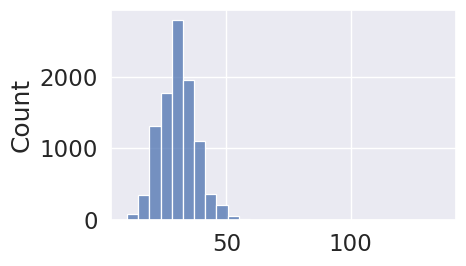

In [3]:
task_name = 'Malaria Bioactivity'
tasks = ['Loge EC50']

raw_filename = "../data/malaria-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename, names = ["Loge EC50", "smiles"])
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [4]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 800

p_dropout= 0.03
fingerprint_dim = 200

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,Loge EC50,smiles,cano_smiles


In [6]:
test_df = remained_df.sample(frac=0.2,random_state=random_seed)
train_df = remained_df.drop(test_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
# print(len(test_df),sorted(test_df.cano_smiles.values))

In [7]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [8]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        optimizer.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()


In [9]:
best_param ={}
best_param["train_epoch"] = 0
best_param["test_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    test_MAE, test_MSE = eval(model, test_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':test_MAE, 'test_MAE':test_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':test_MAE, 'test_MSE':test_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE
        if test_MSE < 1.1:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["test_epoch"] >18):        
        break
    print(epoch, train_MSE, test_MSE)
    
    train(model, train_df, optimizer, loss_function)


0 1.9566191 2.0270927


1 1.4537338 1.5365871


2 1.4644943 1.5498475


3 1.4328877 1.5139116


4 1.4467524 1.530447


5 1.4245591 1.4995061


6 1.3909371 1.4652551


7 1.3651322 1.437524


8 1.3585719 1.4282811


9 1.3350341 1.3945879


10 1.3049569 1.3597442


11 1.2845832 1.337096


12 1.2746837 1.3184736


13 1.3095063 1.3457358


14 1.255205 1.2925601


15 1.2413102 1.2769554


16 1.2583399 1.2876035


17 1.23737 1.2657983


18 1.2448622 1.276041


19 1.2250327 1.2575359


20 1.2220237 1.2525052


21 1.224466 1.2543074


22 1.2215606 1.2523415


23 1.2126206 1.2418107


24 1.2387501 1.2752527


25 1.2240669 1.248483


26 1.2094882 1.2325104


27 1.1976345 1.2251862


28 1.2604736 1.276742


29 1.1977012 1.2318777


30 1.1997037 1.2305651


31 1.1979274 1.221271


32 1.1838958 1.2087045


33 1.1852939 1.206624


34 1.1831957 1.2121091


35 1.1885992 1.2230722


36 1.1784867 1.2079809


37 1.1720744 1.1980628


38 1.1738943 1.197539


39 1.1837188 1.2050413


40 1.1684613 1.1960663


41 1.168122 1.196736


42 1.1683443 1.1933957


43 1.1821659 1.2148433


44 1.1586915 1.187512


45 1.1624347 1.1861646


46 1.157882 1.1876223


47 1.1604116 1.1909832


48 1.1545955 1.1829473


49 1.1620202 1.1868867


50 1.1668414 1.1884996


51 1.1429524 1.1709919


52 1.14622 1.1812352


53 1.1359833 1.1646281


54 1.1375284 1.1655213


55 1.1757321 1.1994958


56 1.143828 1.1784917


57 1.1352872 1.1677089


58 1.1342089 1.1698881


59 1.1286587 1.1648312


60 1.1225483 1.1577715


61 1.1310209 1.167654


62 1.1274002 1.1694142


63 1.1252373 1.1658629


64 1.1166124 1.154105


65 1.1215934 1.1647917


66 1.1203219 1.1626438


67 1.1330105 1.1631547


68 1.1277564 1.1723636


69 1.1088612 1.1518848


70 1.1171416 1.1641326


71 1.1049939 1.1526706


72 1.1020833 1.1426415


73 1.1128122 1.1655005


74 1.1066085 1.1490788


75 1.0943451 1.1385176


76 1.099099 1.151903


77 1.1069238 1.1585495


78 1.0889386 1.1358103


79 1.0912482 1.1372485


80 1.0847421 1.136344


81 1.0841953 1.133331


82 1.0993217 1.1604714


83 1.0833527 1.1338291


84 1.1181241 1.1651357


85 1.0786582 1.1361616


86 1.0726167 1.1301274


87 1.0713053 1.1314422


88 1.081854 1.1360561


89 1.0663208 1.1270401


90 1.07324 1.1335706


91 1.0697316 1.1255497


92 1.0731975 1.1280429


93 1.0789077 1.1371062


94 1.075908 1.1484334


95 1.0603782 1.1273215


96 1.0676545 1.130426


97 1.0600119 1.1365818


98 1.0609496 1.1227765


99 1.0567273 1.1175607


100 1.0529013 1.1315603


101 1.0459572 1.1213708


102 1.0485592 1.1171789


103 1.0532197 1.1175073


104 1.0463945 1.124525


105 1.0819744 1.1497707


106 1.0410924 1.117693


107 1.0358864 1.1150974


108 1.0310307 1.1147788


109 1.0299524 1.1128081


110 1.0308627 1.1194355


111 1.029773 1.1205208


112 1.0541928 1.126561


113 1.0664788 1.1397402


114 1.045531 1.1194541


115 1.0277933 1.1079488


116 1.0226458 1.106077


117 1.0169693 1.1154025


118 1.0175132 1.1181526


119 1.0167036 1.1074605


120 1.0236503 1.1062568


121 1.0070808 1.097078


122 1.0613928 1.1422087


123 1.019436 1.1285952


124 1.0085582 1.1141751


125 1.0026939 1.0973368


126 1.0209688 1.1309568


127 1.0269077 1.129697


128 1.0309087 1.1209848


129 1.001249 1.1222705


130 0.9988808 1.1067381


131 0.9892157 1.1003764


132 0.99267083 1.0985645


133 1.0014352 1.0993792


134 0.99548334 1.090705


135 0.98108345 1.0908452


136 0.97981375 1.0938936


137 0.9787054 1.0977331


138 0.9930614 1.0996941


139 0.9979799 1.1254058


140 0.97624886 1.090726


141 0.97350097 1.1026037


142 0.9810057 1.1164372


143 0.98895186 1.0962261


144 0.9673586 1.0858413


145 0.9740496 1.0986465


146 0.9705868 1.1063943


147 0.9890674 1.1170355


148 0.9736558 1.0977719


149 0.9700397 1.0882127


150 0.9781137 1.1270965


151 0.96136355 1.0910147


152 0.96348065 1.0926479


153 0.95586765 1.0851883


154 0.9597404 1.0887624


155 0.9540476 1.0782527


156 0.99486494 1.1165247


157 0.9516204 1.0829995


158 0.97241396 1.0950452


159 0.9462212 1.0963805


160 0.96761656 1.0937132


161 0.9419611 1.0931267


162 0.95240873 1.0855203


163 0.9376828 1.0792427


164 0.95197505 1.1123896


165 0.9372872 1.087247


166 0.93972135 1.0946745


167 0.9531969 1.118701


168 0.9306328 1.0925629


169 0.93672734 1.1121489


170 0.9263699 1.0863272


171 0.9331432 1.112287


172 0.950946 1.0942578


173 0.92100483 1.0897418


174 0.9415199 1.1006709


175 0.9276737 1.0792797


In [10]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

best epoch: 155 
 test MSE: 1.0782527
